# <strong>Introduction: 2022 Qatar World Cup Power Ranking and Winner(Simulation)</strong><br>
Introduction: Predicting the winner of 2022 Qatar World Cup<br>
Method:
- 1. Read Data
- 2. Feature Selection:
    - Goal Difference = AVG(Offense Score) - AVG(Diffense Score)
    - Current Rank
    - Average Rank for 10 years
    - Not Friendly Game

- 3. Model Selection: Logistic Regresion, XGBoost, Gradinet Boosting, Ada Boosting
- 4. Simulation
- 5. Visualization


This project was based on the following project: https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner/notebook<br>
Data Source:
- results: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017 (modified by Jay Jung)
- Qatar2022-teams: Written by Jay Jung
- fifaRanking2020-10-06: https://www.kaggle.com/datasets/cashncarry/fifaworldranking (modified by Jay Jung)<br>

Data Modification: Modified data because the affecting data for this World Cup are up to 10 years. <br>
Wokred with Goolge Colab and Jupyter Notebook

## 1. Read Data

In [150]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')

rankings = pd.read_csv('./worldCupData/fifaRanking2020-10-06.csv', encoding='windows-1252')
matches = pd.read_csv('./worldCupData/results.csv', encoding='windows-1252')
groups = pd.read_csv('./worldCupData/Qatar2022-teams.csv')

In [151]:
# Unified countries name
rankings = rankings.replace({"IR Iran": "Iran"})
rankings = rankings.replace({"Korea Republic": "South Korea"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
matches['date'] = pd.to_datetime(matches['date'])
matches = matches.replace({"United States": "USA"})

In [152]:
#rankings.head()

## 2. Feature Engineering

### 2.1 Extract team list for 2022 Qatar World Cup

In [153]:
country_list = groups['Team'].values.tolist()
country_list = sorted(country_list)
# country_list

In [154]:
# Get Average rankings for 10 years for each country
avgRanking = rankings.groupby(['country_full']).mean()
avgRanking = avgRanking.reset_index()

In [155]:
matches.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral'],
      dtype='object')

Different number of data <br>
so extract countries which join the 2022 Qatar World Cup <br><br>
Countries: ['Senegal',
 'Qatar',
 'Netherlands',
 'Ecuador',
 'Iran',
 'England',
 'USA',
 'Wales',
 'Argentina',
 'Saudi Arabia',
 'Mexico',
 'Poland',
 'Denmark',
 'Tunisia',
 'France',
 'Australia',
 'Germany',
 'Japan',
 'Spain',
 'Costa Rica',
 'Morocco',
 'Croatia',
 'Belgium',
 'Canada',
 'Switzerland',
 'Cameroon',
 'Brazil',
 'Serbia',
 'Uruguay',
 'South Korea',
 'Portugal',
 'Ghana']

In [156]:
# Different number of data
home_offense = matches.groupby(['home_team']).mean()['home_score'].fillna(0)
len(home_offense)

283

In [157]:
# Different number of data
away_offense = matches.groupby(['away_team']).mean()['away_score'].fillna(0)
len(away_offense)

278

### 2.2 Goal Difference(GD) for each team
Offense Score = avg(home score) * 0.3 + avg(away score) * 0.7
(Additional points are given because it is more difficult to score in away games.)<br>
Defense Score = avg(away score) + avg(home score)<br>
GD = Offense Score - Deffense Score

In [158]:
home = home_offense.to_frame().reset_index()
away = away_offense.to_frame().reset_index()

In [159]:
home = home[home['home_team'].isin(country_list)].reset_index()
home = home.drop(['index'], axis = 1)
#home

In [160]:
away = away[away['away_team'].isin(country_list)].reset_index()
away = away.drop(['index'], axis = 1)
# away

In [161]:
wc_score = pd.DataFrame()
wc_score['country_name'] = country_list
wc_score['offense_score'] = round((home['home_score'] * 0.3 + away['away_score'] * 0.7), 2) # Most gmaes are away game so I weighted more in away_score
# wc_score

In [162]:
home_diffense = matches.groupby(['home_team']).mean()['away_score'].fillna(0)
away_diffense = matches.groupby(['away_team']).mean()['home_score'].fillna(0)
home = home_diffense.to_frame().reset_index()
away = away_diffense.to_frame().reset_index()
home = home[home['home_team'].isin(country_list)].reset_index()
home = home.drop(['index'], axis = 1)
away = away[away['away_team'].isin(country_list)].reset_index()
away = away.drop(['index'], axis = 1)
wc_score['diffense_score'] = round(home['away_score'] * 0.3 + away['home_score'] * 0.7, 2) # most games are away
wc_score['GD'] = (wc_score['offense_score'] - wc_score['diffense_score']) # Goals Difference
# wc_score

### 2.3 Average Rankings for 10 years

In [163]:
avgRanking = avgRanking[['country_full', 'rank']]
avgRanking.head()

,country_full,rank
0,Afghanistan,146.207921
1,Albania,56.524752
2,Algeria,37.930693
3,American Samoa,190.396040
4,Andorra,173.128713


In [164]:
avgRank = avgRanking[avgRanking['country_full'].isin(country_list)].reset_index()
avgRank = avgRank.drop(['index'], axis = 1)
# avgRank

### 2.4 Win Rate for each Team

In [165]:
matches['score_difference_home'] = matches['home_score'] - matches['away_score']
matches['score_difference_away'] = matches['away_score'] - matches['home_score']
matches['home win'] = ((matches['score_difference_home'] > 0) & (matches['tournament'] != 'Friendly'))
matches['away win'] = ((matches['score_difference_away'] > 0) & (matches['tournament'] != 'Friendly'))
matches = matches[(matches['home_team'].isin(country_list)) | matches['away_team'].isin(country_list)]
# matches

In [166]:
winRate = {'country' : [], 'winrate': []}
for i in country_list:
    count = matches[(matches['home_team'] == i) | (matches['away_team'] == i) == True]
    winRate['country'].append(i)
    winRate['winrate'].append((len(count[count['home win']] == True) + len(count[count['away win']] == True)) / len(count))
    
winRate = pd.DataFrame(winRate)
#winRate

In [167]:
curRank = rankings[rankings['country_full'].isin(country_list)]
curRank = curRank.loc[curRank['rank_date'] == '2022-10-06'][['country_full', 'rank']]
curRank = curRank.sort_values('country_full')
wc_score['current_rank']= curRank['rank'].values.tolist()
wc_score['avgRank'] = round(avgRank['rank'], 2)
wc_score['winRate'] = round(winRate['winrate'], 2)
wc_score = wc_score[['country_name', 'current_rank', 'avgRank', 'GD', 'winRate']]
wc_score = wc_score.sort_values('current_rank').reset_index().drop(['index'], axis = 1)
wc_score

,country_name,current_rank,avgRank,GD,winRate
0,Brazil,1,5.06,1.63,0.47
1,Belgium,2,4.49,1.40,0.65
2,Argentina,3,4.47,0.97,0.49
3,France,4,9.69,0.86,0.47
4,England,5,9.68,1.28,0.54
5,Spain,7,6.72,1.18,0.55
6,Netherlands,8,14.15,0.98,0.54
7,Portugal,9,6.43,1.05,0.53
8,Denmark,10,23.78,0.75,0.51
9,Germany,11,5.98,1.17,0.56


In [168]:
corr = wc_score.corr()
corr.style.background_gradient()

,current_rank,avgRank,GD,winRate
current_rank,1.000000,0.827994,-0.675269,-0.299605
avgRank,0.827994,1.000000,-0.502896,-0.313125
GD,-0.675269,-0.502896,1.000000,0.383654
winRate,-0.299605,-0.313125,0.383654,1.000000


current_rank and avgRank have high correlation.

In [169]:
# Merge matches and rankings data for the simulation
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [170]:
matches.tail().columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'score_difference_home',
       'score_difference_away', 'home win', 'away win', 'rank_date_home',
       'rank_home', 'country_full_home', 'country_abrv_home',
       'total_points_home', 'previous_points_home', 'rank_change_home',
       'confederation_home', 'rank_date_away', 'rank_away',
       'country_full_away', 'country_abrv_away', 'total_points_away',
       'previous_points_away', 'rank_change_away', 'confederation_away'],
      dtype='object')

In [171]:
matches['score_diff'] = matches['home_score'] - matches['away_score']
matches['win'] = matches['score_diff'] > 0 # draw is not win
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches['rank_diff'] = matches['rank_home'] - matches['rank_away']
matches['avg_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['avg_diff'] = -(matches['total_points_home'] - matches['total_points_away'])/10

## 3. Modeling

In [172]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt

In [173]:
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

### 3.1 Model Selection

In [174]:
X, y = matches.loc[:,['avg_rank', 'rank_diff', 'avg_diff', 'is_stake']], matches['win']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42)
acc_score = {'model_name' : [], 'score': []}

In [175]:
clf = linear_model.LogisticRegression(random_state = 42, max_iter = 1000)
clf.fit(X_train, y_train)
clf_acc = clf.score(X_test, y_test)
acc_score['model_name'].append('logistic regression')
acc_score['score'].append(clf_acc)

In [176]:
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgb.fit(X_train, y_train)
xgb_acc = xgb.score(X_test, y_test)
acc_score['model_name'].append('XGB')
acc_score['score'].append(xgb_acc)

In [177]:
gbdt = GradientBoostingClassifier(random_state = 42)
gbdt.fit(X_train, y_train)
gbdt_acc = gbdt.score(X_test, y_test)
acc_score['model_name'].append('GBDT')
acc_score['score'].append(gbdt_acc)

In [178]:
ada = AdaBoostClassifier(random_state = 42)
ada.fit(X_train, y_train)
ada_acc = ada.score(X_test, y_test)
acc_score['model_name'].append('ADA')
acc_score['score'].append(ada_acc)

In [179]:
acc_score = pd.DataFrame(acc_score)

In [180]:
acc_score = acc_score.sort_values(['score'], ascending = False)

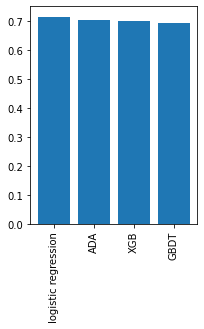

In [181]:
plt.figure(figsize=(3,4))
plt.bar(acc_score['model_name'], acc_score['score'])
plt.xticks(rotation = 90)
plt.show()

Best accuracy is lositic regression for this data

### 3.2 Performance of Model 

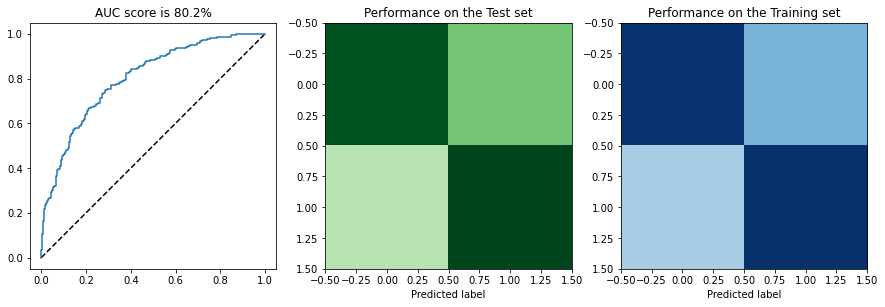

In [182]:
clf = linear_model.LogisticRegression()

features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', clf)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.3}%'.format(100 * roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Greens', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

## 4. Simulation

In [183]:
wc_score = wc_score.set_index('country_name')

In [184]:
wc_score['country_abrv'] = ['BRA', 'BEL', 'ARG', 'FRA', 'ENG', 'ESP', 'NED', 'POR', 'DEN', 'GER', 'CRO', 'MEX',
                            'URU','SUI', 'USA', 'SEN', 'WAL', 'IRN', 'SER','MAR', 'JPN', 'POL', 'KOR', 'TUN',
                           'CRC', 'AUS', 'CAN', 'CMR', 'ECU', 'QAT', 'KSA', 'GHA']

In [185]:
from itertools import combinations
margin = 0.05
groups['points'] = 0
groups['total_prob'] = 0
groups = groups.set_index('Team')
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

In [186]:
set(groups['Group'])

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'}

In [187]:
for group in set(groups['Group']):
    print('----------------------Group {}----------------------'.format(group))
    for home, away in combinations(groups.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        #row = row.fillna(0)
        home_rank = wc_score.loc[home, 'current_rank']
        home_avg = wc_score.loc[home, 'avgRank']
        opp_rank = wc_score.loc[away, 'current_rank']
        opp_avg = wc_score.loc[away, 'avgRank']
        row['avg_rank'] = (home_rank + opp_rank) / 2
        row['rank_diff'] = home_rank - opp_rank
        row['avg_diff'] = home_avg - opp_avg
        home_win_prob = model.predict_proba(row)[:,1][0]
        groups.loc[home, 'total_prob'] += home_win_prob
        groups.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            groups.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            groups.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            groups.loc[home, 'points'] += 1
            groups.loc[away, 'points'] += 1

----------------------Group C----------------------
Argentina vs. Saudi Arabia: Argentina wins with 0.76
Argentina vs. Mexico: Argentina wins with 0.58
Argentina vs. Poland: Argentina wins with 0.67
Saudi Arabia vs. Mexico: Mexico wins with 0.79
Saudi Arabia vs. Poland: Poland wins with 0.69
Mexico vs. Poland: Mexico wins with 0.58
----------------------Group H----------------------
Uruguay vs. South Korea: Uruguay wins with 0.56
Uruguay vs. Portugal: Portugal wins with 0.56
Uruguay vs. Ghana: Uruguay wins with 0.77
South Korea vs. Portugal: Portugal wins with 0.71
South Korea vs. Ghana: South Korea wins with 0.68
Portugal vs. Ghana: Portugal wins with 0.80
----------------------Group D----------------------
Denmark vs. Tunisia: Denmark wins with 0.63
Denmark vs. France: France wins with 0.59
Denmark vs. Australia: Denmark wins with 0.68
Tunisia vs. France: France wins with 0.73
Tunisia vs. Australia: Draw
France vs. Australia: France wins with 0.73
----------------------Group B-------

In [188]:
pairing = [0, 3, 4, 7, 8, 11, 12, 15, 1, 2, 5, 6, 9, 10, 13, 14]

groups = groups.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = groups.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['Round_of_16', 'Quarterfinal', 'Semifinal', 'Final']

labels = list()
odds = list()

for f in finals:
    print("----------------------{}----------------------".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = wc_score.loc[home, 'current_rank']
        avgRank = wc_score.loc[home, 'avgRank']
        opp_rank = wc_score.loc[away, 'current_rank']
        opp_avg = wc_score.loc[away, 'avgRank']
        row['avg_rank'] = (home_rank + opp_rank) / 2
        row['rank_diff'] = home_rank - opp_rank
        row['avg_diff'] = home_avg - opp_avg
        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(wc_score.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        wc_score.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

----------------------Round_of_16----------------------
Netherlands vs. USA: Netherlands wins with probability 0.56
Argentina vs. Denmark: Argentina wins with probability 0.57
Spain vs. Croatia: Spain wins with probability 0.53
Brazil vs. Uruguay: Brazil wins with probability 0.59
Senegal vs. England: England wins with probability 0.62
Mexico vs. France: France wins with probability 0.58
Germany vs. Belgium: Belgium wins with probability 0.58
Switzerland vs. Portugal: Portugal wins with probability 0.56


----------------------Quarterfinal----------------------
Netherlands vs. Argentina: Argentina wins with probability 0.55
Spain vs. Brazil: Brazil wins with probability 0.55
England vs. France: France wins with probability 0.51
Belgium vs. Portugal: Belgium wins with probability 0.54


----------------------Semifinal----------------------
Argentina vs. Brazil: Brazil wins with probability 0.52
France vs. Belgium: Belgium wins with probability 0.52


----------------------Final---------

## 5. Visualization of result

In [189]:
# ## using graphviz 
# !apt-get -qq install -y graphviz && pip install -q pydot
# import pydot
# ## Those are not necessary but for the safe compile 
# !apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz

In [190]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

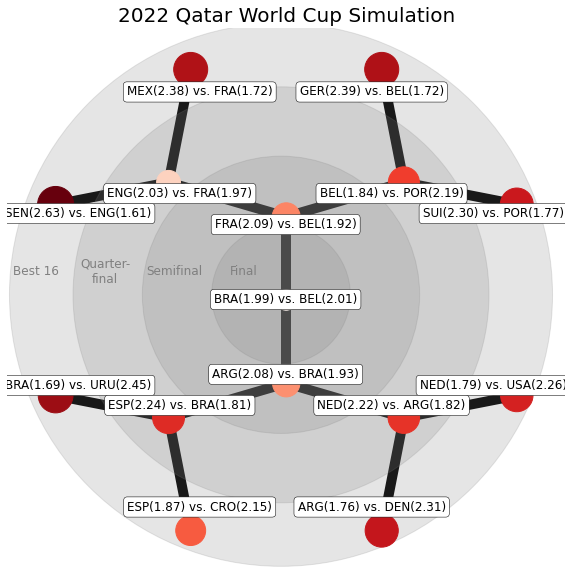

In [191]:
node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = nx.nx_agraph.graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('2022 Qatar World Cup Simulation', fontsize=20)
plt.show()

<strong>The Winner of my 2022 Qatar World Cup Simulation is Brazil